# Tutorial 2: Analysis of 10X Visium DLPFC data

The following tutorials demonstrates how to use PAST to derive latent embeddings and decipher spatial domains on Slice 151507 of human dorsolateral prefrontal cortex (DLPFC) datasets([Maynard, et al., 2021](https://www.nature.com/articles/s41593-020-00787-0)).

There are two parts in this tutorial:

+ **Integrating self-prior data to analyze Slice 151507.** This part will show you how to utilize target preprocessed gene expression matrix as self-prior matrix to obtain latent embeddings and spatial clusters on Slice 151507 of DLPFC datasets.

+ **Integrating external-prior data to analyze Slice 151507.** This part will show you how to utilize the remaining slices in DLPFC dataset to construct pseudo-bulk external-prior matrix for latent feature extraction and spatial clustering on Slice 151507 of DLPFC datasets.

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/anaconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

You can uncomment and execute the following command to download the DLPFC dataset in AnnData format.

In [3]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/10X_DLPFC.h5ad

In [4]:
## DLPFC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
DLPFC = sc.read_h5ad(filename="10x_DLPFC.h5ad")
DLPFC.var_names_make_unique()

DLPFC = DLPFC[DLPFC.obs["ManualAnnotation"].astype(str)!="nan", :]
DLPFC_151507 = DLPFC[DLPFC.obs["sample_id"]=="151507", :]
DLPFC_151507

View of AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'ManualAnnotation'
    var: 'source', 'type', 'gene_id', 'gene_version', 'gene_name'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata = DLPFC_151507.copy()
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata = adata[:, adata.var_names.str.startswith('MT-') == False]
adata

View of AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'ManualAnnotation'
    var: 'source', 'type', 'gene_id', 'gene_version', 'gene_name', 'mt'
    uns: 'spatial'
    obsm: 'spatial'

## Integrating self-prior matrix to analyze slice 151507

We set a random seed for all random process for reproducibility.

In [6]:
past.setup_seed(666)
sdata = DLPFC_151507.copy()

Next, we filter out genes expressed in less than three spots, follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) tailed for spatial transcriptomics to normalize and logarithmize the count matrix, and then select the top 3000 spatial variable genes based on the [Geary'C Index](https://www.jstor.org/stable/2986645).

In [7]:
sdata = past.preprocess(sdata, min_cells=3, n_tops=3000, gene_method="gearyc")

We initialize PAST model with `d_lat=50`, `k_neighbors=6`.

In [8]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target DLPFC_151507 anndata as self-prior marix.

In [9]:
PAST_model.model_train(sdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:6.11s Loss: 10.336335
Epoch:20 Time:5.38s Loss: 5.303733
Epoch:30 Time:5.50s Loss: 4.280472
Epoch:40 Time:5.32s Loss: 3.574325
Epoch:50 Time:5.48s Loss: 3.029444
Epoch:60 Time:5.40s Loss: 2.526999
Epoch:70 Time:5.60s Loss: 2.090571
Epoch:80 Time:5.22s Loss: 1.686509
Epoch:90 Time:5.30s Loss: 1.314816
Epoch:100 Time:5.30s Loss: 1.004479
Epoch:110 Time:5.17s Loss: 0.734262
Epoch:120 Time:5.19s Loss: 0.546181
Epoch:130 Time:5.18s Loss: 0.427973
Epoch:140 Time:5.21s Loss: 0.343339
Epoch:150 Time:5.18s Loss: 0.288010
Epoch:160 Time:5.24s Loss: 0.255994
Epoch:170 Time:5.19s Loss: 0.226360
Epoch:180 Time:5.34s Loss: 0.210046
Epoch:190 Time:5.31s Loss: 0.197738
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [10]:
sdata = PAST_model.output(sdata)

The result of mclust and louvain with default resolution is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [11]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["ManualAnnotation"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [12]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["ManualAnnotation"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.891, K: 0.868, mF1: 0.870, wF1: 0.891
Mclust metrics:			ARI: 0.523, AMI: 0.661, NMI: 0.662, FMI:0.610, Comp: 0.676, Homo: 0.647
Dlouvain metrics:		ARI: 0.309, AMI: 0.528, NMI: 0.529, FMI:0.415, Comp: 0.466, Homo: 0.612


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

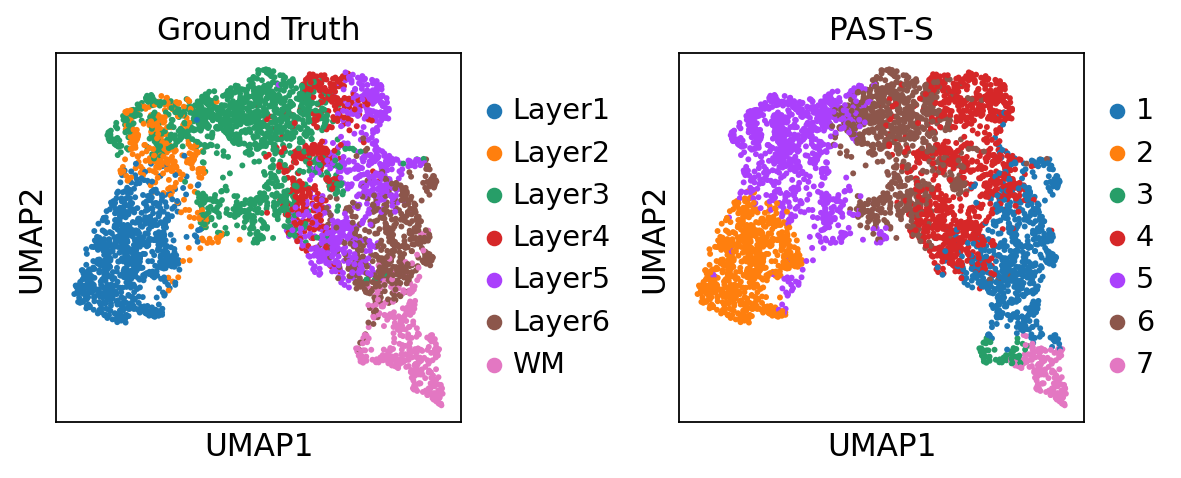

In [13]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["ManualAnnotation", "mclust"], title=["Ground Truth", "PAST-S"], wspace=0.4)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

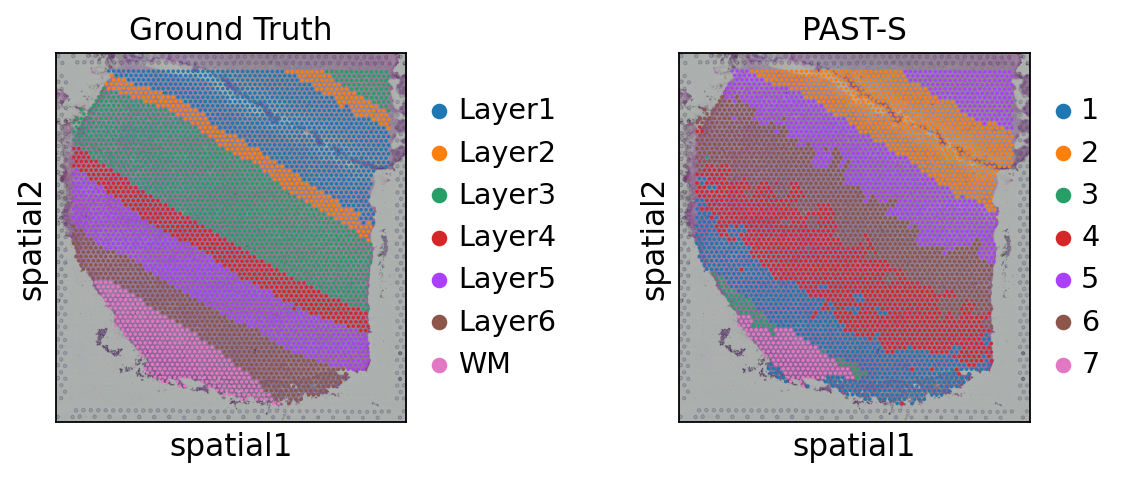

In [14]:
sc.pl.spatial(sdata, color=["ManualAnnotation", "mclust"], library_id="151507", 
              title=["Ground Truth", "PAST-S"], wspace=0.4)

## Integrating external-prior matrix to analyze slice 151507

Similarly, We set a random seed for all random process for reproducibility.

In [15]:
past.setup_seed(666)
sdata = DLPFC_151507.copy()

As done above, We also filter out genes expressed in less than three spots, follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix, and then select the top 3000 spatial variable genes based on the [Geary'C Index](https://www.jstor.org/stable/2986645).

In [16]:
sdata = past.preprocess(sdata, min_cells=3, n_tops=3000, gene_method="gearyc")

Here we utilize remaining slices in DLPFC dataset as reference data to construct external-prior matrix, denoted as `rdata`. We first align the gene set of `rdata` to that of `sdata` through `past.integration()` function, preprocess `rdata`, and then construct pseudo-bulk external-prior matrix using `past.get_bulk()` function based on spatial domain labels of reference data.

In [17]:
rdata = DLPFC[DLPFC.obs["sample_id"]!="151507", :]
rdata = past.integration(rdata, sdata)
rdata = past.preprocess(rdata, min_cells=None, target_sum=None, n_tops=None)
rdata = past.get_bulk(rdata, key="ManualAnnotation")
rdata

add 0 zero features to reference; Current total 3000 genes
DownSample 1 times to get enough pseudo bulks!
bulk_data's shape: (14, 3000)


AnnData object with n_obs × n_vars = 14 × 3000

We initialize PAST model with the same parameters.

In [18]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST with pseudo-bulk external-prior matrix constructed in the last step.

In [19]:
PAST_model.model_train(sdata, rdata=rdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:4.77s Loss: 10.577247
Epoch:20 Time:4.62s Loss: 5.362225
Epoch:30 Time:4.61s Loss: 4.329756
Epoch:40 Time:4.67s Loss: 3.645602
Epoch:50 Time:4.65s Loss: 3.124809
Epoch:60 Time:4.62s Loss: 2.656288
Epoch:70 Time:4.62s Loss: 2.231842
Epoch:80 Time:4.62s Loss: 1.832304
Epoch:90 Time:4.61s Loss: 1.467626
Epoch:100 Time:4.63s Loss: 1.147336
Epoch:110 Time:4.63s Loss: 0.870166
Epoch:120 Time:4.65s Loss: 0.664653
Epoch:130 Time:4.67s Loss: 0.521196
Epoch:140 Time:4.71s Loss: 0.410905
Epoch:150 Time:4.71s Loss: 0.336117
Epoch:160 Time:4.66s Loss: 0.290968
Epoch:170 Time:4.60s Loss: 0.254061
Epoch:180 Time:4.73s Loss: 0.229102
Epoch:190 Time:4.83s Loss: 0.211511
Epoch:200 Time:4.67s Loss: 0.200202
Model Converge


We then obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [20]:
sdata = PAST_model.output(sdata)

The result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [21]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["ManualAnnotation"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [22]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["ManualAnnotation"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.891, K: 0.868, mF1: 0.871, wF1: 0.892
Mclust metrics:			ARI: 0.556, AMI: 0.695, NMI: 0.696, FMI:0.631, Comp: 0.684, Homo: 0.707
Dlouvain metrics:		ARI: 0.494, AMI: 0.652, NMI: 0.653, FMI:0.577, Comp: 0.604, Homo: 0.710


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

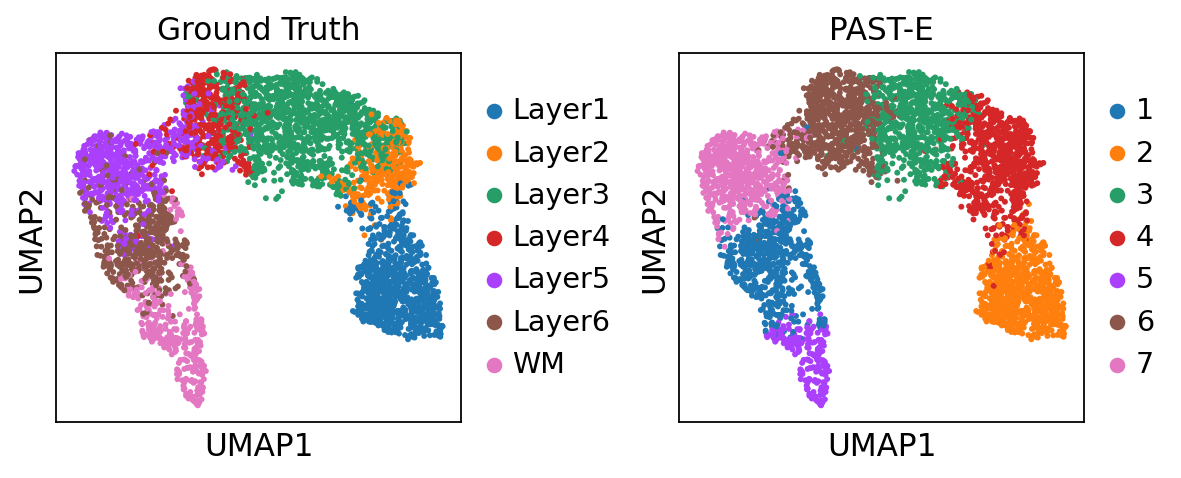

In [23]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["ManualAnnotation", "mclust"], title=["Ground Truth", "PAST-E"], wspace=0.4)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

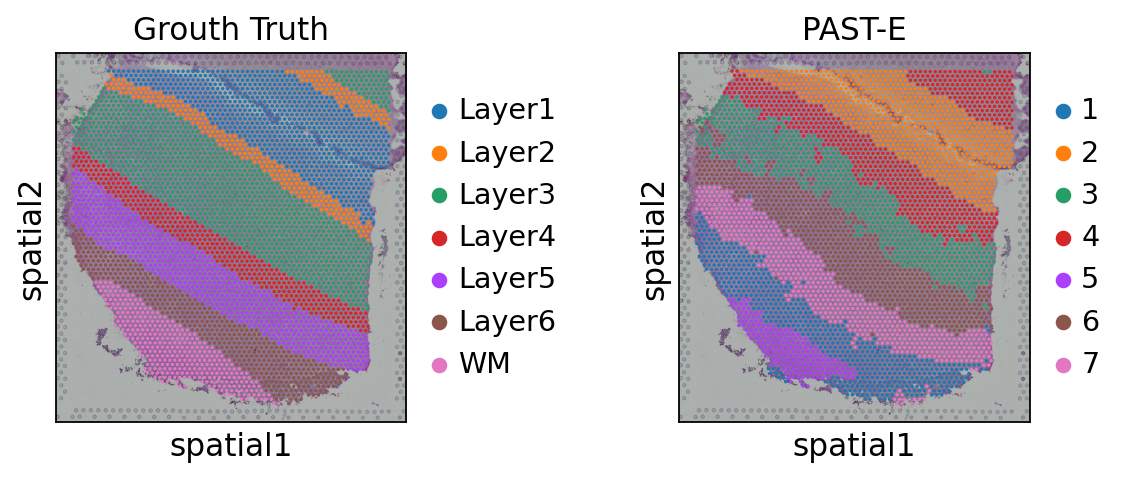

In [24]:
sc.pl.spatial(sdata, color=["ManualAnnotation", "mclust"], library_id="151507",
              title=["Grouth Truth", "PAST-E"], wspace=0.4)